# Primerjava Covid 19 z gripo, vpliv ukrepov, vpliv povprečne starosti populacije države na smrtnost !

In [23]:
import pandas as pandas
import os
import sys
import json
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output
from ipywidgets      import Dropdown
from bqplot          import Lines, Figure, LinearScale, DateScale, Axis
from ipyleaflet      import Map, GeoJSON, WidgetControl
from ipywidgets import IntSlider, ColorPicker, ToggleButton
import numpy as np
from collections import defaultdict
from scipy.stats import multivariate_normal as mvn
%matplotlib inline
sys.path.append(os.getcwd() + '/modules')
from zansModule     import read_population_by_sex, get_sum_population_array, my_round, get_age_distribution_array
from zansModule     import draw_bar_chart_distribution, draw_bar_chart_mortality, death_count_country_year, month_deaths

from enejBModule    import test_enej
from jakaRModule    import test_jaka
from nikolajPModule import test_nikolaj
from rokSModule import drawPlot, compare, showCountermeasures

# reading data from files
with open('../podatki/countries.geo.json') as f:
    countries = json.load(f)
pop_by_sex = read_population_by_sex()  

reader = pandas.read_csv(r"..\podatki\corona_worldwide.csv")
virus_array = reader.to_numpy()    #create array of data

In [24]:
def display_data_for_country(country_name, year, show_bool):
    print("Država: " + country_name + "\nLeto: " + str(year))
    pop_data_set = get_sum_population_array(pop_by_sex, country_name)
    rounded_year = my_round(year)
    
    avg_age = float(pop_by_sex[(pop_by_sex['Region-Country'] == country_name) & (pop_by_sex["Date"] == rounded_year)]["avg_age"])
    this_year_pop = [i for i in pop_data_set if i[0] == rounded_year]
    avg_deaths = month_deaths(death_count_country_year(country_name, year))
    
    if type(avg_deaths[0]) is float:
        avg_deaths = int(avg_deaths[0]), int(avg_deaths[1])
    
    print("Populacija v tej državi leta {} je {:.2f} tisoč".format(rounded_year, this_year_pop[0][1]))
    print("Povprečna starost prebivalca v tej državi leta {} je bila {:.1f}".format(rounded_year, avg_age))
    print("V tej državi je vsak mesec leta {} umrlo povprečno {} ljudi. V celem letu pa {} ljudi"
          .format(year, str(avg_deaths[0]), str(avg_deaths[1])))
    
    if show_bool:
        draw_bar_chart_distribution(get_age_distribution_array(pop_by_sex, country_name, rounded_year), country_name, rounded_year)
        draw_bar_chart_mortality(year, year-1, country_name)

## Interaktivni zemljevid, ki izpiše št. prebivalcev, povprečno starost prebivalcev, št. ljudi ki je v tej državi umrlo v danem letu ter kako je Covid-19 vplival nanjo

Država: United Kingdom
Leto: 2018
Try another year data missing for this one !{}
Populacija v tej državi leta 2020 je 67886.00 tisoč
Povprečna starost prebivalca v tej državi leta 2020 je bila 40.6
V tej državi je vsak mesec leta 2018 umrlo povprečno (No data) ljudi. V celem letu pa (No data) ljudi


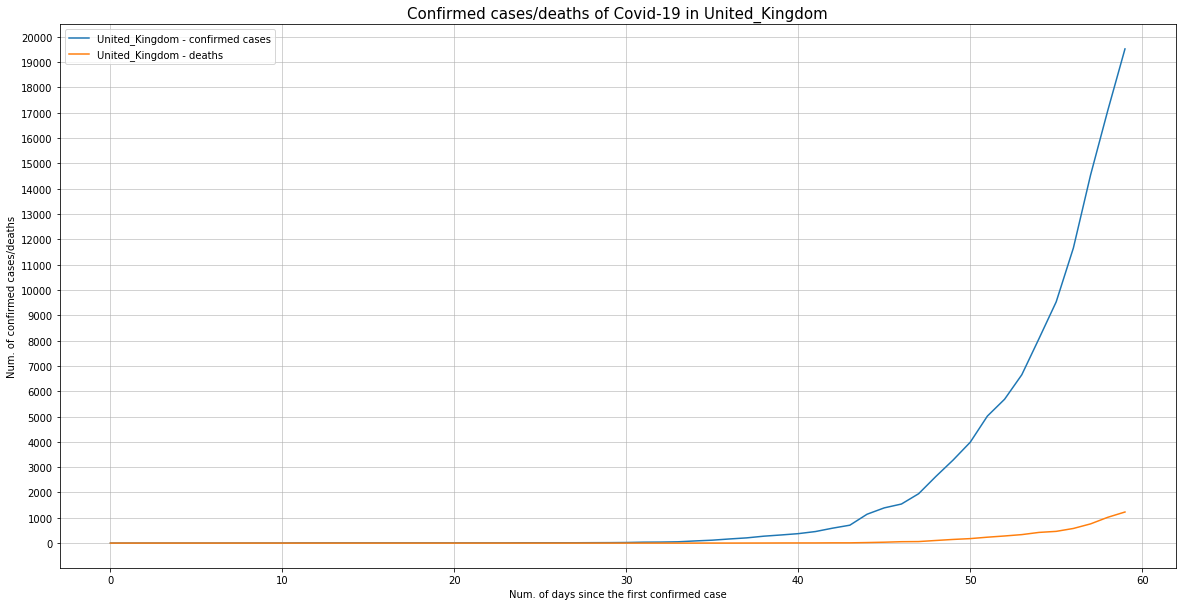

28.2.2020: potrjen prvi primer v Veliki Britaniji
1.3.2020: potrjeni primeri v vseh državah Velike Britanije
11.3.2020: vlada deklarira pandemijo
15.3.2020: odsvetovanje potovanj kamorkoli, če ne nujna
20.3.2020: vlade sprejela sklep o zaprtju vseh šol, restavracij, barov, s nekaterimi izjemami
23.3.2020: zaprtje celotne Velike Britanije
23.3.2020: prepoved vseh nenujnih potovanj 
23.3.2020: prepoved kontakta ljudi s ljudmi ki niso iz posameznega gospodinjstva 
23.3.2020: zapiranje vseh manjših poslovalnic, prizorišč, javnih objektov,... 
23.3.2020: razglasitev slogana "stay at home"
15.4.2020: podaljšanje ukrepov vsaj do 9.5.
3.5.2020: popularna veriga trgovin B&Q odpira svoja vrata
10.5.2020: dovoljenje vsem ki ne morejo delati od doma, da gredo v službo, s izogibanjem uporabe javnega prevoza  
10.5.2020: sprememba slogana v "stay alert", ki so ga druge države VB zanikale
11.5.2020: objava "Our plan to rebuild", 60-strani dolg dokument, v katerem Johnson napove nadaljno strategijo pr

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [25]:
import time
m = Map(zoom=3)

geo = GeoJSON(data=countries, style={'fillColor': 'white', 'weight': 0.5}, hover_style={'fillColor': '#1f77b4'}, name='Countries')

year_slider = IntSlider(description='Year:', min=1980, max=2020, value=2018)
slider_control = WidgetControl(widget=year_slider, position='topright')
m.add_control(slider_control)

show_graphs = ToggleButton(description='Show Graph')
button_control = WidgetControl(widget=show_graphs, position='topright')
m.add_control(button_control)

def click_handle(event=None, feature=None, **kwargs): # must be none if nothing is given

            year = year_slider.value
            clear_output(True)
        #
            try:
                display_data_for_country(kwargs['properties']['name'], year, show_graphs.value)
                drawPlot(virus_array, kwargs['properties']['name'], "both")
                showCountermeasures(kwargs['properties']['name'])
                display(m)
            except:
                pass

            
geo.on_click(click_handle)
m.add_layer(geo)
display(m)

Graf za Covid-19 je narejen od prvega dne, ko se je virus pojavil v določeni državi. Prikazoval naj bi hitrost širjenja virusa in s tem tudi število posledično umrlih ljudi. Prav tako bi se ob izbiri države morali prikazati ukrepi, ki jih je država sprejela za preprečitev širjenja virusa, vendar nam je to uspelo narediti le za 2 državi (Slovenijo ter VB) zaradi težavnosti pri iskanju podatkov - vse podakte bi morali prepisati ročno.


Za prikaz širjenja Covid-19 je napisana tudi funkcija __compare(država1, država2, query)__ -> _query = {"cases", "deaths"}._

S njo lahko prikažemo ter primerjamo dve državi po hitrosti naraščanja primerov oz. smrti (to izberemo v "query"). Zaradi izredne velike razlike med nekaterimi državami, je graf lahko v nekaterih primer precej nerazviden, ampak je zato v državah s približnim enakim rastom/številom ker všečen.

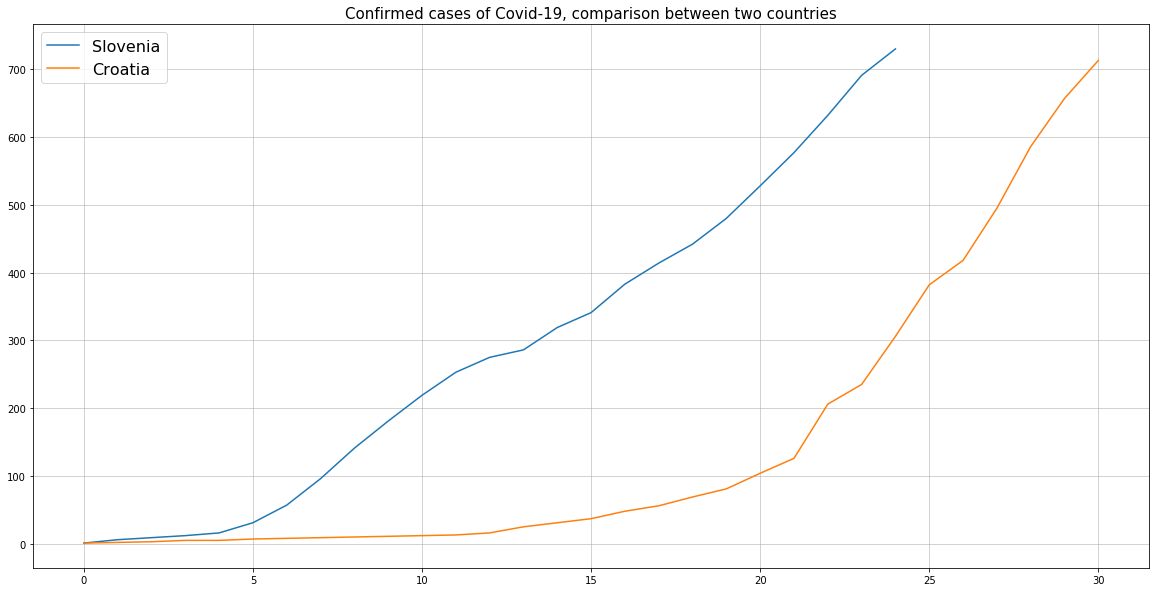

In [4]:
compare(virus_array, "slovenia", "croatia", "cases")

In [5]:
"""
BACKUP CODE - ŽAN

m = Map(zoom=3)

geo = GeoJSON(data=countries, style={'fillColor': 'white', 'weight': 0.5}, hover_style={'fillColor': '#1f77b4'}, name='Countries')

year_slider = IntSlider(description='Year:', min=1980, max=2020, value=2018)
slider_control = WidgetControl(widget=year_slider, position='topright')
m.add_control(slider_control)

show_graphs = ToggleButton(description='Show Graph')
button_control = WidgetControl(widget=show_graphs, position='topright')
m.add_control(button_control)

def click_handle(event=None, feature=None, **kwargs): # must be none if nothing is given
    if feature is not None:
        year = year_slider.value
        clear_output(True)
        display(m)
        display_data_for_country(kwargs['properties']['name'], year, show_graphs.value)

geo.on_click(click_handle)
m.add_layer(geo)
display(m)

"""
clear_output(True)

## Primerjava smrtnosti za Francijo in Anglijo leto 2019 in 2020

## Primerjava rasti COVID okužb po državah

In [6]:
import sys
import os
sys.path.append(os.getcwd() + '/modules')
import jakaRModule as jaka

In [7]:
# Read data for Covid-19 growth comparison
(dataFrame,dateRange,countries) = jaka.readGrowthData()

In [8]:
# Create a dictionary, containing weekly statistics
weeklyStatsDict = jaka.createWeeklyStatsDict(dataFrame,dateRange,countries)

##### Opis podatkov

V prejšnjem koraku ima vsaka država za vsak teden od začetka beleženja Covid-19 število okuženih in mrtvih. Če bi gručili po teh podatkih, bi populacija države igrala veliko vlogo. Ker pa tega nočemo (primerjamo le rast), se v naslednjem koraku za vsak teden izračuna razmerje naslednji/prejšnji teden. S tem dobimo za vsak teden nek koeficient, ki prikazuje rast števila okuženih oziroma mrtvih. Ko gručimo na ta način, populacija ne igra vloge.

In [9]:
# Create a dictionary, that contains growth coefficients for every week in date range
weeklyCoefficientsDict = jaka.createWeeklyCoefficientsDict(weeklyStatsDict)

In [10]:
# Create matrices for later use in model creation
(caseMatrix, deathMatrix, labels) = jaka.createMatricesAndLabels(weeklyCoefficientsDict, 100)

In [11]:
caseLinkage = jaka.createLinkage(caseMatrix)
deathLinkage = jaka.createLinkage(deathMatrix)

In [12]:
%matplotlib inline
# jaka.drawDendrogram(caseLinkage, labels, title="Države, gručene po tedenskem koeficientu rasti okuženih")

Za prikaz podatkov smo izbrali dendrogram, saj po našem mnenju lepo grafično prikazuje rezultate. Na grafu vidimo, katere države so si podobne glede na to, kakšna je bila rast števila mrtvih za Covid-19.

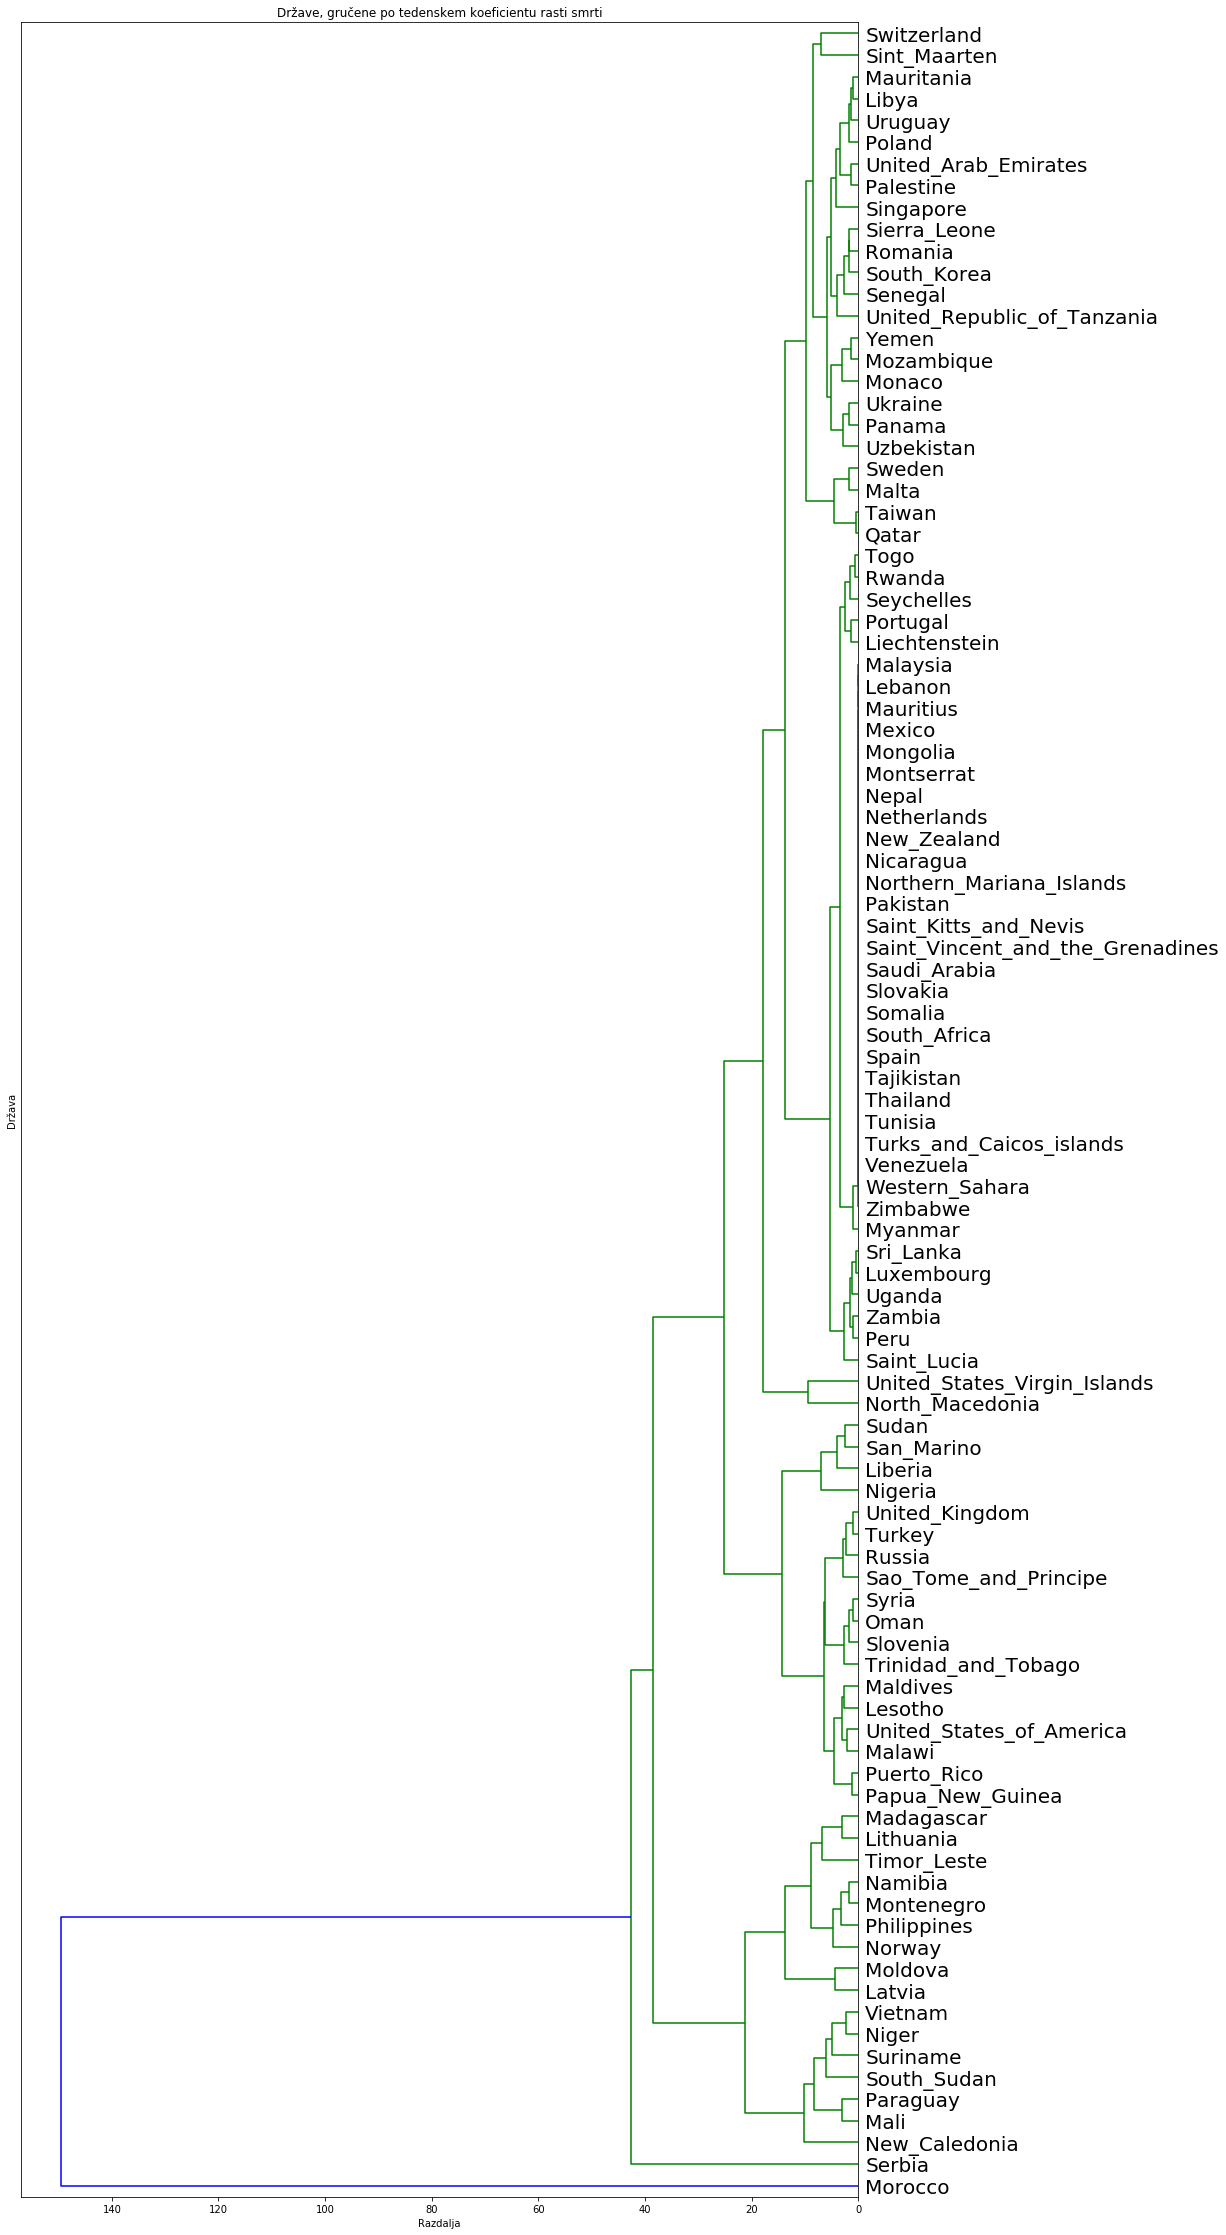

In [13]:
jaka.drawDendrogram(deathLinkage, labels, title="Države, gručene po tedenskem koeficientu rasti smrti")

## Gručenje držav glede na mesečno umrljivost

In [14]:
# Read total population data
(dataFrame, countryList) = jaka.readTotalPopulationData()

In [15]:
# Year months for later use
months = ['January','February','March','April','May','June','July','August','September','October','November','December']

In [16]:
# Read the dataframe which contains deaths per month for year 2015
deathDataFrame = jaka.readDeathData(year=2015)

##### Opis podatkov

V naslednjem koraku pripravimo podatke za izdelavo modela. Podatki so v obliki slovarja, kjer so ključi države. Vsak ključ ima za vrednost polje, ki predstavlja umrljivost za vsak mesec v letu. Izbrali smo leto 2015.

In [17]:
# Create a dictionary with country for key and array of deaths per each month per million eg. {"Slovenia": [2,3,5,2,4,2,4,5,3,2,4,5]}
monthDeathDict = jaka.createMonthDeathDictionary(deathDataFrame,dataFrame,countryList,months)

In [18]:
# Creating matrix and labels
(matrix, labels) = jaka.createMatrixAndLabels(monthDeathDict)

In [19]:
# Create a linkage
mortalityLinkage = jaka.createLinkage(matrix)

Graf prikazuje, katere države si si med sabo najbolj podobne po stopnji mesečne umrljivosti skozi leto 2015. Iz podatkov lahko vidimo, da imajo države s podobno geografsko pozicijo podobne stopnje smrtnosti. V glavnem je model razdelil države na 2 večji skupini. Kar opazimo je to, da je v zeleni več držav nižje razvitosti. (ne vse, ampak več kot v rdeči)

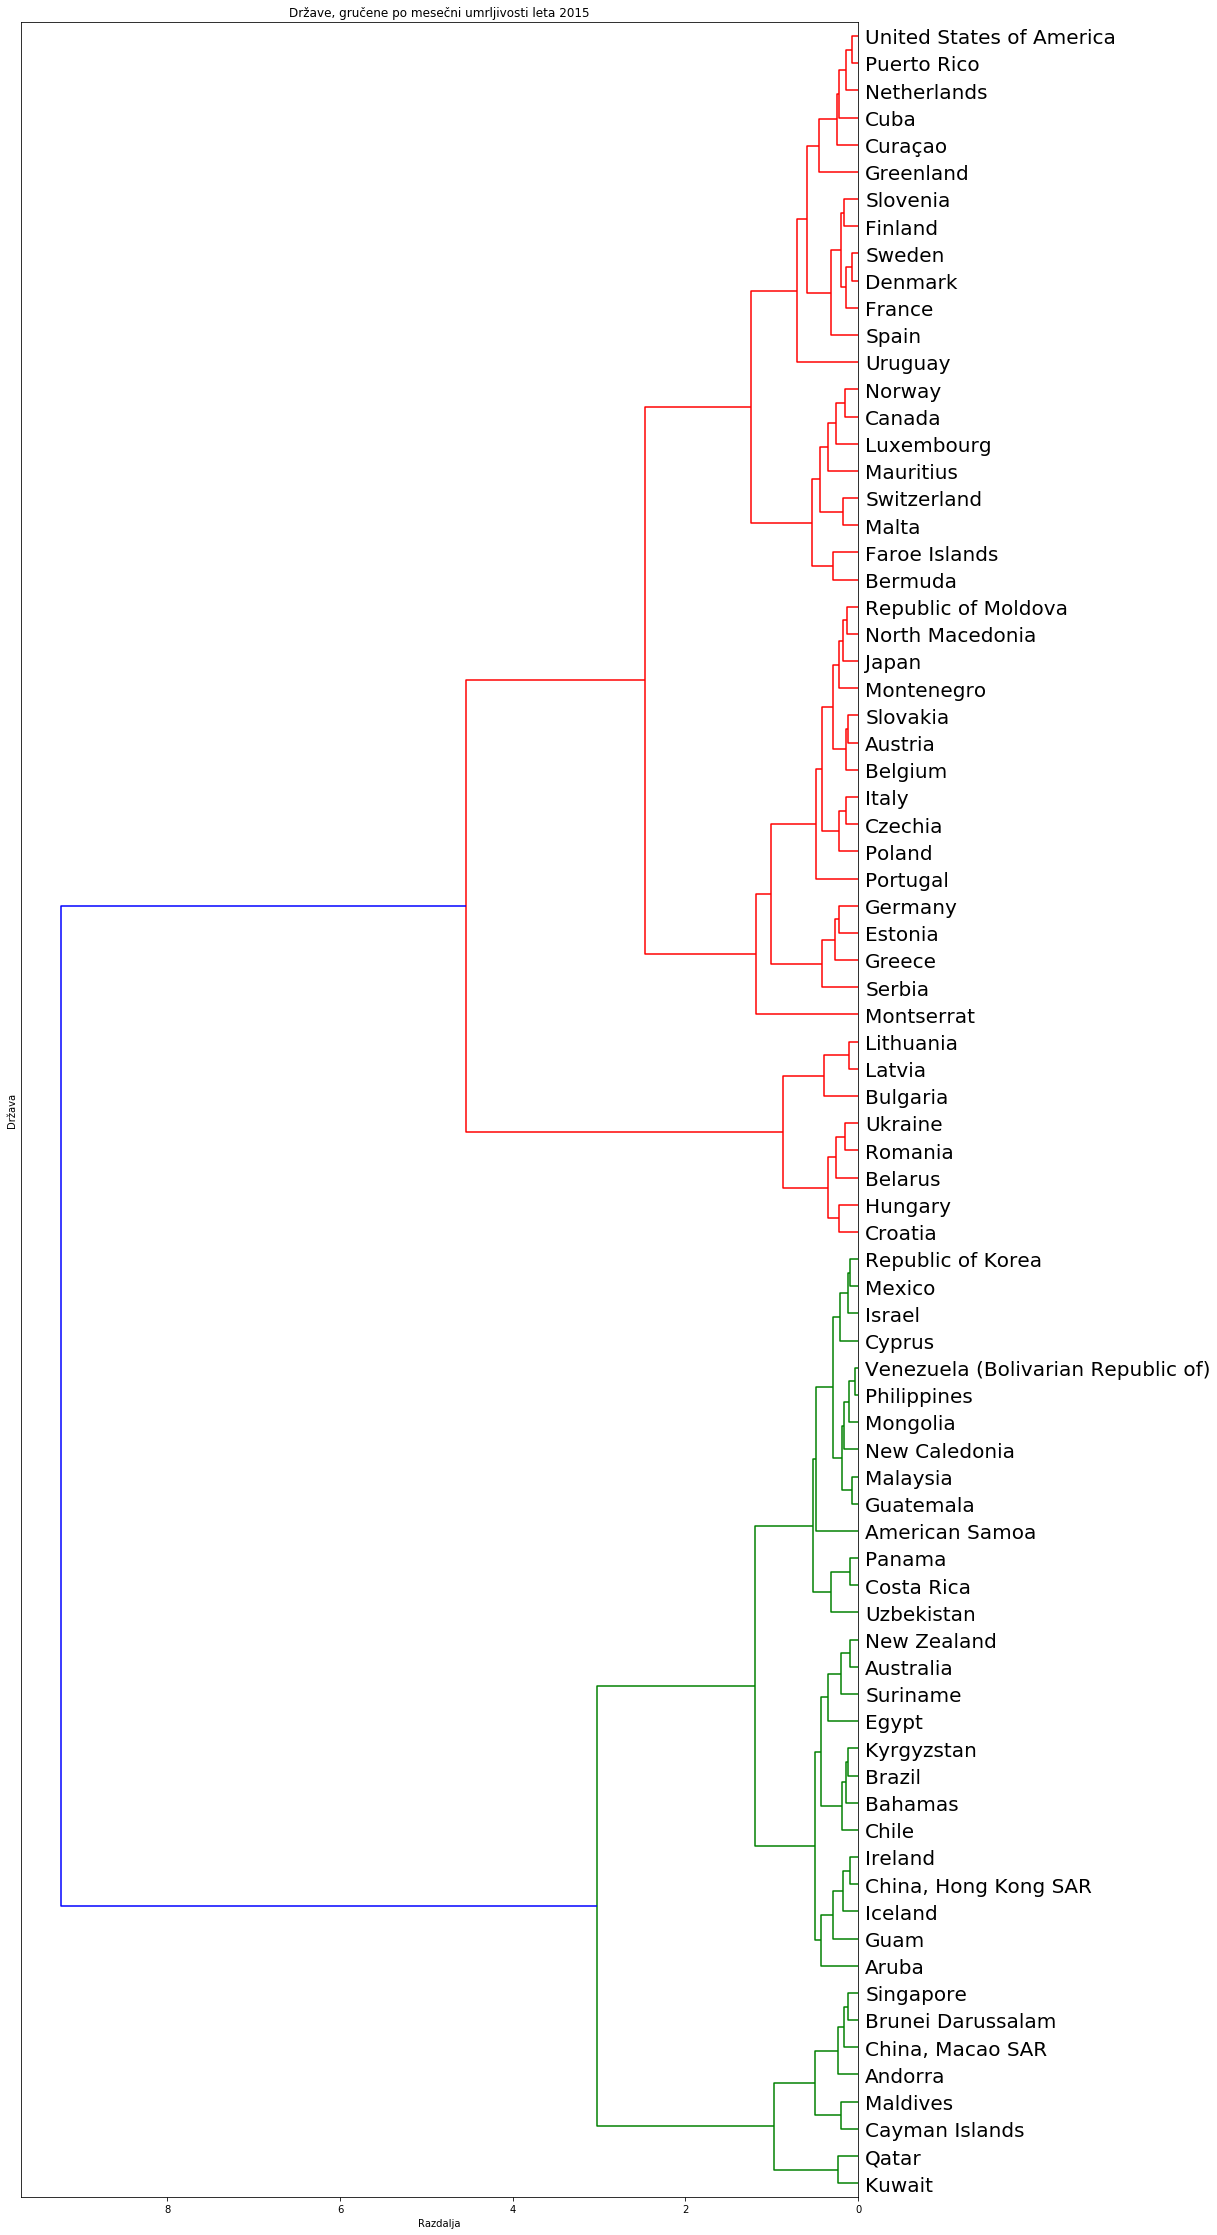

In [20]:
# Draw a dendrogram
jaka.drawDendrogram(mortalityLinkage, labels, title="Države, gručene po mesečni umrljivosti leta 2015")

# Enej

In [7]:
import pandas as pandas
import os
import json
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [8]:
def read_population_by_sex():
    rows_to_skip = [i for i in range(0, 16)]  
    rows_to_skip.extend([i for i in range(17, 272)])   # odstranjevanje vrstic ki bi delale probleme
    rows_to_skip.extend([i for i in range(362, 377)])
    names  =["Region-Country", "Date", "0-4", "5-9",  "10-14", "15-19", "20-24", "25-29", 
             "30-34", "35-39", "40-44", "45-49", "50-54", "55-59",  "60-64", "65-69", "70-74", "75-79",
             "80-84", "85-89", "90-94", "95-99", "100+"]

    main_set = pandas.read_excel('../podatki/POPULATION_BY_AGE_BOTH_SEXES.xlsx', 
                                 usecols=(2, 7, 8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28),
                                    skiprows=rows_to_skip,
                                    names=names)
    main_set["population_sum"] = np.NaN
    main_set["avg_age"] = np.NaN

    for index, row in main_set.iterrows():
        temp_sum = 0
        for num_range, num in row[2:-2].iteritems():
            temp_sum += num

        main_set.loc[index,"population_sum"] = float(temp_sum)

        pop_age = 0        # mogoče zamenji z mediano 
        age_range = 2
        for num_range, num in row[2:-2].iteritems():
            pop_age += (num / temp_sum) * age_range
            age_range += 5
        main_set.loc[index,"avg_age"] = float(pop_age)
    return main_set

In [9]:
def priprava(avg_age_all_df,country):
    #priprava podatkov za starost
    avg_age_all_df = pop_by_sex.loc[:, ['Date','Region-Country', 'avg_age']] #avg_age_date_region-country
    avg_age_df = avg_age_all_df.loc[avg_age_all_df['Region-Country'] == country]
    avg_age_df_2020 = avg_age_df.loc[avg_age_df['Date'] == 2020]
    avg_age_df_spain = avg_age_df_2020.loc[avg_age_df['Region-Country'] == country]

    #priprava podatkov za corono
    corona_smrti_koeficient = pandas.read_csv("../podatki/corona_latest.csv")
    corona_smrti_koeficient = corona_smrti_koeficient.loc[corona_smrti_koeficient['year'] == 2020]
    corona_smrti_koeficient = corona_smrti_koeficient.loc[corona_smrti_koeficient['countriesAndTerritories'] == country]
    corona_final1 = corona_smrti_koeficient.loc[:, ['deaths','popData2018']]
    corona_final_koeficient = corona_final1
    corona_final_koeficient['koeficient'] = ((corona_final_koeficient['deaths']*100)/corona_final_koeficient['popData2018']) *10000
    smrti_koeficienti = corona_final_koeficient.loc[:, ['koeficient']]
    smrti_koeficienti = smrti_koeficienti[smrti_koeficienti["koeficient"]!=0] #razlicen od 0
    smrti_koeficienti = smrti_koeficienti[smrti_koeficienti["koeficient"]>1] #vecji od 1
    smrti =smrti_koeficienti['koeficient'].mean()
    smrti
    smrt=[smrti]
    skupenDF2=avg_age_df_spain
    skupenDF2['koeficient']=smrt
    skupenDF2
    return skupenDF2

In [10]:
def iteracija_drzave(avg_age_all_df):
    drzave_df = avg_age_all_df.loc[:, ['Region-Country']]
    drzave_df = drzave_df['Region-Country'].unique()

    df_countries = priprava(avg_age_all_df,drzave_df[0])
    length = len(drzave_df) 
    i = 1
    # Iterating using while loop 
    while i < length: 
        df_countries = df_countries.append(priprava(avg_age_all_df,drzave_df[i]))
        i += 1

    df_countries = df_countries.dropna()
    return df_countries

In [11]:
def linearna(pop):
    avg_age_all_df = pop.loc[:, ['Date','Region-Country', 'avg_age']]
    df_countries = iteracija_drzave(avg_age_all_df)
    X = df_countries.iloc[:, 2].values.reshape(-1, 1) # values converts it into a numpy array
    Y = df_countries .iloc[:, 3].values.reshape(-1, 1) # -1 means that calculate the dimension of rows, but have 1 column
    linear_regressor = LinearRegression()
    linear_regressor.fit(X, Y)
    Y_pred = linear_regressor.predict(X)
    plt.scatter(X, Y)
    plt.plot(X, Y_pred, color='red')
    plt.xlabel("Starost")
    plt.ylabel("Koeficient smrti")

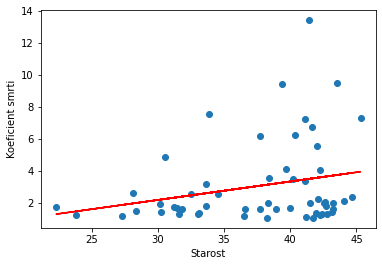

In [12]:
# ta spremen
# pop_by_sex = read_population_by_sex()
linearna(pop_by_sex)